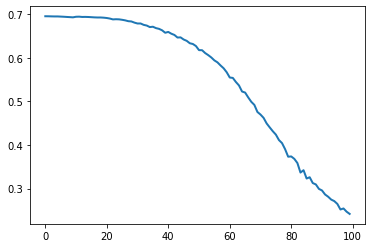

Confusion Matrix is from Part 1a is:  [[ 7.  1.]
 [ 0. 12.]]
Confusion Matrix from Part 1b is: [[ 7  1]
 [ 1 11]]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix


def fit_NeuralNetwork(X_train,y_train,alpha,hidden_layer_sizes,epochs):
    """
    Inputs:
        X_train: X train is the training dataset that is composed of N, d-dimensional vectors.
        y_train: y train is an N − dimensional vector that consists of the corresponding class observations for each training vector in X train.
        alpha: alpha is the step-size used to update the weights in the NN.
        hidden_layer_sizes: hidden layer sizes contains information about the number of nodes in each hidden layer
        epochs: epochs represents the number of times the training process will pass through the entire training set to tune the weight parameters.
    Outputs:
        err: err is a list that contains the average error computed at each epoch.
        weights: weights contains the final weights obtained from training the NN using the back propagation algorithm.
    """
    # Initialize the epoch errors
    err=np.zeros((epochs,1))

    # Initialize the architecture
    N, d = X_train.shape
    X0 = np.ones((N,1))
    X_train = np.hstack((X0,X_train))
    d=d+1
    L = len(hidden_layer_sizes)
    L=L+2

    #Initializing the weights for input layer
    weight_layer = np.random.normal(0, 0.1, (d,hidden_layer_sizes[0])) #np.ones((d,hidden_layer_sizes[0]))
    weights = []
    weights.append(weight_layer) #append(0.1*weight_layer)

    #Initializing the weights for hidden layers
    for l in range(L-3):
        weight_layer = np.random.normal(0, 0.1, (hidden_layer_sizes[l]+1,hidden_layer_sizes[l+1]))
        weights.append(weight_layer)

    #Initializing the weights for output layers
    weight_layer= np.random.normal(0, 0.1, (hidden_layer_sizes[l+1]+1,1))
    weights.append(weight_layer)

    for e in range(epochs):
        choiceArray=np.arange(0, N)
        np.random.shuffle(choiceArray)
        errN=0
        for n in range(N):
            index=choiceArray[n]
            x=np.transpose(X_train[index])
            #Model Update: Forward Propagation, Backpropagation
            # update the weight and calculate the error
            X,S = forwardPropagation(x,weights)
            g = backPropagation(X,y_train[index],S,weights)
            weights = updateWeights(weights, g, alpha)
            errN += errorPerSample(X, y_train[index])
        err[e]=errN/N
    return err, weights

def forwardPropagation(x, weights):
    """
    Inputs:
        x: The input x is d + 1 dimensional. With 1st component of x is 1, and remaining d components represent input feature vector xn
        weights: weights is a list where each element l is a matrix representing the weights of edges between layer l and l + 1
    Outputs:
        retX: X is the output at all nodes residing in all layers of the NN. X is a list where the l thelement is a vector of size dl+ 1
        retS: S is the input into all nodes located in all layers of the NN, composed of L − 1 elements
    """
    l=len(weights)+1
    currX = x
    retS=[]
    retX=[]
    retX.append(currX)

    # Forward Propagate for each layer
    for i in range(l-1):

        currS=np.dot(np.transpose(weights[i]),currX) #Dot product between the layer and the weight matrix
        retS.append(currS)
        currX=currS
        if i != len(weights)-1:
            for j in range(len(currS)):
                currX[j]= activation(currS[j]) #
            currX= np.hstack((1,currX))
        else:
            currX= outputf(currS) #Apply the output activation
        retX.append(currX)
    return retX,retS

def errorPerSample(X,y_n):
    """
    Inputs:
        X: the output RetX of forward propagation
        y_n: class label observed for the input vector x n.
    Outputs:
        eN: This is the error contributed at the last layer x L. This is a single-dimensional output.
    """
    #eN is the errorf from the last layer
    eN = errorf(X[len(X)-1],y_n)
    return eN

def backPropagation(X,y_n,s,weights):
    """
    Inputs:
        X: the output RetX of forward propagation
        y_n: class label observed for the input vector x n.
        s: the output RetS of forward propagation
        weights: weights is a list where each element l is a matrix representing the weights of edges between layer l and l + 1
    Outputs:
        g: This function will output a list g which contains all the error gradients computed for all the weights in the NN.
    """
    #x:0,1,...,L
    #S:1,...,L
    #weights: 1,...,L
    l=len(X)
    delL=[]

    # To be able to complete this function, you need to understand this line below
    # In this line, we are computing the derivative of the Loss function w.r.t the
    # output layer (without activation). This is dL/dS[l-2]
    # By chain rule, dL/dS[l-2] = dL/dy * dy/dS[l-2] . Now dL/dy is the derivative Error and
    # dy/dS[l-2]  is the derivative output.
    delL.insert(0,derivativeError(X[l-1],y_n)*derivativeOutput(s[l-2]))
    curr=0

    # Now, let's calculate dL/dS[l-2], dL/dS[l-3],...
    for i in range(len(X)-2, 0, -1): #L-1,...,0
        delNextLayer=delL[curr]
        WeightsNextLayer=weights[i]
        sCurrLayer=s[i-1]

        #Init this to 0s vector
        delN=np.zeros((len(s[i-1]),1))

        #Now we calculate the gradient backward
        #Remember: dL/dS[i] = dL/dS[i+1] * W(which W???) * activation
        for j in range(len(s[i-1])): #number of nodes in layer i - 1
            for k in range(len(s[i])): #number of nodes in layer i
                #calculate delta at node j
                delN[j]=delN[j]+ WeightsNextLayer[j][k] * delNextLayer[k] * derivativeActivation(sCurrLayer[j])

        delL.insert(0,delN)

    # We have all the deltas we need. Now, we need to find dL/dW.
    # It's very simple now, dL/dW = dL/dS * dS/dW = dL/dS * X
    g=[]
    for i in range(len(delL)):
        rows,cols=weights[i].shape
        gL=np.zeros((rows,cols))
        currX=X[i]
        currdelL=delL[i]
        for j in range(rows):
            for k in range(cols):
                #Calculate the gradient using currX and currdelL
                gL[j,k]= np.dot(currX[j],currdelL[k])
        g.append(gL)
    return g

def updateWeights(weights,g,alpha):
    """
    Inputs:
        weights: weights represent the current weights assigned to all edges in the NN.
        g: g is a list that contains all the gradients of the weights as computed by the backPropagation function.
        alpha: alpha is the step-size of the weight update.
    Outputs:
        nW: nW will contain the updated weights.
    """
    nW=[]
    for i in range(len(weights)):
        rows, cols = weights[i].shape
        currWeight=weights[i]
        currG=g[i]
        for j in range(rows):
            for k in range(cols):
                #Gradient Descent Update
                currWeight[j,k]= currWeight[j,k] - alpha*currG[j][k]#
        nW.append(currWeight)
    return nW

def activation(s):
  """
  Inputs:
     s: single-dimensional real-valued number.
  Output:
     single-dimensional output of performing a ReLU operation on the input.
  """
  return relu(s)

def relu(x):
  """
  Inputs:
      x: single-dimensional real-valued number.
  Output:
      performing a ReLU operation on the input.
  """
  return max(0.0,x)

def derivativeActivation(s):
  """
  Inputs:
      s: The input to this function is a single-dimensional real-valued number.
  Output:
      The output is the derivative of the activation function θ(s).
  """
  if s<=0:
    return 0
  elif s>0:
    return 1

def outputf(s):
  """
  Inputs:
      s: The input to this function is a single-dimensional real-valued number.
  Output:
      The output of this function is a single-dimensional value which is evaluated using the logistic regression function..
  """
  return (1/(1+np.exp(-s)))

def derivativeOutput(s):
  """
  Inputs:
      s： The input to this function is a single-dimensional real-valued number.
  Output:
      The output of this function is derivative of the sigmoid function evaluated at s
  """
  return ((np.exp(s))/((np.exp(s)+1)**2))

def errorf(x_L,y):
  """
  Inputs:
      x_L: The input to this function is a single-dimensional real-valued number.
        (output from the NN model which is obtained by applying forward propagation to xn)
      y: The input to this function is a single-dimensional discrete variable which takes values in the set { +1,-1 }
        (class that the training data point x nbelongs to)
  Outputs:
      The output of this function is evaluated via the log loss error function
  """
    #Fill in the return values
  if y==1:
    return -np.log(x_L)
  else:
    return -np.log(1-x_L)

def derivativeError(x_L,y):
  """
  Inputs:
      x_L: The input to this function is a single-dimensional real-valued number.
        (output from the NN model which is obtained by applying forward propagation to xn)
      y: The input to this function is a single-dimensional discrete variable which takes values in the set { +1,-1 }
        (class that the training data point x nbelongs to)
  Outputs:
      The output of this function is the derivative of the error function evaluated at x_L
  """
  if y==1:
    return -1/x_L
  else:
    return 1/(1-x_L)

def pred(x_n,weights):
    """
    Inputs:
        x: The input x is d + 1 dimensional. With 1st component of x is 1, and remaining d components represent input feature vector xn
        weights: weights is a list where each element l is a matrix representing the weights of edges between layer l and l + 1
    Outputs:
        c: the class the input belongs to
    """
    #prediction using the forwardPropagation function
    retX,retS= forwardPropagation(x_n,weights)
    l=len(retX)

    # Return -1 if probability lesser than 0.5
    # Else return 1
    if retX[l-1]<0.5:
        return -1
    else:
        return 1

def confMatrix(X_train,y_train,w):
    """
    Inputs:
        X_train: composed of the training points
        y_train: composed of the corresponding observations.
        w: w is the final weight list computed via the training of the NN
    Outputs:
        The output of this function will be a four-by-four matrix.
    """
    #This is a copy from PA1
    eCount=np.zeros((2,2))
    j=0
    row, col = X_train.shape
    X0 = np.ones((row,1))
    X_train = np.hstack((X0,X_train))
    for j in range(row):
        if (pred(X_train[j],w)==-1 and y_train[j]==-1):
            eCount[0,0]=eCount[0,0]+1
        elif (pred(X_train[j],w)==1 and y_train[j]==-1):
            eCount[0,1]=eCount[0,1]+1
        elif (pred(X_train[j],w)==1 and y_train[j]==1):
            eCount[1,1]=eCount[1,1]+1
        else:
            eCount[1,0]=eCount[1,0]+1
    return eCount

def plotErr(e,epochs):
    """
    Inputs:
        e: e is the error list containing the average error at each epoch of the training process.
        epochs: epochs is a single-dimensional parameter that denotes the number of iterations  through the entire training set to tune the NN weight parameters.
    Outputs:
        This function will plot the error over the training epochs.
    """
    #Plot the function using plt.plot(...,...,linewidth=2.0)
    x = np.arange(epochs)
    plt.plot(x,e,linewidth=2.0)
    plt.show()

def test_SciKit(X_train, X_test, Y_train, Y_test):
    """
    Inputs:
        X_train: composed of the training points
        X_test: composed of the testing points
        Y_train: output observed in the training set
        Y_test: output observed in the testing set
    Outputs:
        cM: This function will output the confusion matrix obtained for the test dataset.
    """
    clf = MLPClassifier(alpha=0.00001, hidden_layer_sizes=(30,10), random_state=1)
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    matrix = confusion_matrix(Y_test, y_pred)
    return matrix



def test_Part1():
    from sklearn.datasets import load_iris
    X_train, y_train = load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X_train[50:],y_train[50:],test_size=0.2, random_state=1)

    for i in range(80):
        if y_train[i]==1:
            y_train[i]=-1
        else:
            y_train[i]=1
    for j in range(20):
        if y_test[j]==1:
            y_test[j]=-1
        else:
            y_test[j]=1

    err,w=fit_NeuralNetwork(X_train,y_train,1e-2,[30, 10],100)

    plotErr(err,100)

    cM=confMatrix(X_test,y_test,w)

    sciKit=test_SciKit(X_train, X_test, y_train, y_test)

    print("Confusion Matrix is from Part 1a is: ",cM)
    print("Confusion Matrix from Part 1b is:",sciKit)

test_Part1()
